#Week 7
Question 8
(Optional Programming Exercises)
- Implement the basic non-local means type of inpainting approach. Do this both for still and for video, where the search for similar patches in the latter is across multiple frames.
- For a given image, compute at every pixel the inner product between the gradient of the Laplacian and the level lines normal, this being the main term in one of the inpainting techniques we learned. Display it and analyze its behavior.
- For a given video, implement a very simple inpainting technique: At every pixel to be filled-in, inpaint it with the median of the values (if available) for pixels at the same spatial position corresponding to N frames before and N frames after, varying the value of N. Extend this to consider camera motion, in particular by exploiting registration techniques as available in Matlab and other packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

import cv2
import scipy.ndimage.filters

from images2gif import writeGif

##2. Inner product between the gradient of the Laplacian and the level lines normal

http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#laplacian

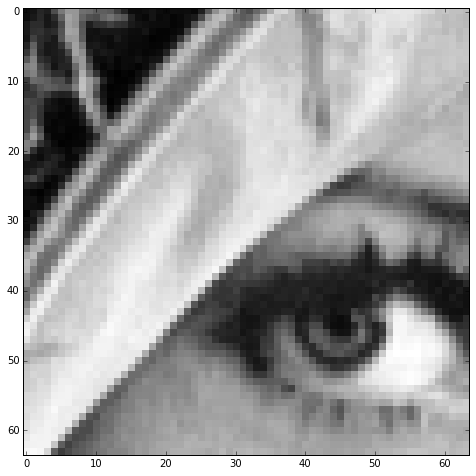

In [2]:
img = cv2.cvtColor(cv2.imread('images/4.2.04.tiff'), cv2.COLOR_BGR2GRAY)
img = img[220:-228,220:-228]

#convert to float!
img = img.astype(np.float)
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img, "gray", interpolation="nearest")

__Level lines normal: Perpendicular to the gradient of image__

Calculate gradient & gradient normal:

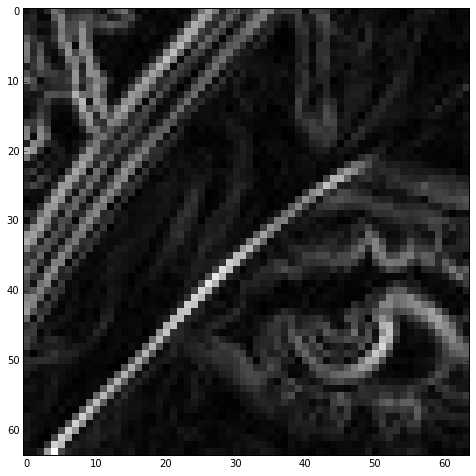

In [3]:
grad = np.gradient(img)
grad_abs = np.sqrt(grad[0]**2 + grad[1]**2)

n = (-1*grad[1], grad[0])  # abs of n and abs of grad are the same

plt.figure(figsize=(8, 8))
imgplt = plt.imshow(grad_abs, "gray", interpolation="nearest")

Visualize Gradient

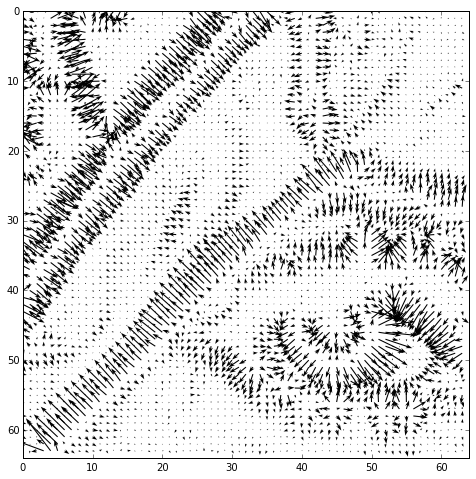

In [4]:
scale = 1000
num = 65
x = np.linspace(0, img.shape[1], num).astype(np.int)
y = np.linspace(0, img.shape[0], num).astype(np.int)
x, y = np.meshgrid(x[:-1], y[:-1])

vx = grad[1][y,x]
vy = grad[0][y,x] #axis is flipped!

plt.figure(figsize=(8, 8))
plt.quiver(x, y, vx, -vy, pivot='origin', scale=scale, headwidth=4, headlength=6)
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

Visualize N

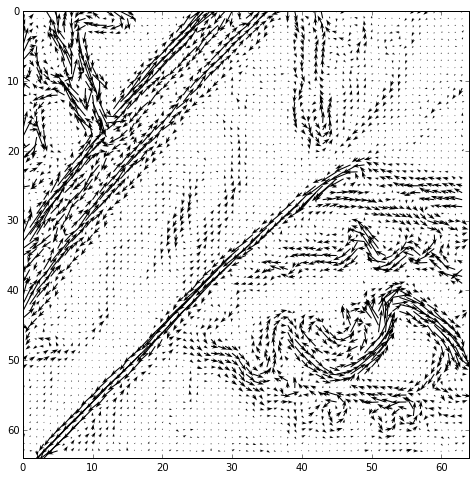

In [5]:
vx = n[1][y,x]
vy = n[0][y,x] #axis is flipped!

plt.figure(figsize=(8, 8))
plt.quiver(x, y, vx, -vy, pivot='origin', scale=scale, headwidth=4, headlength=6)
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

__Laplacian: 2nd derivative__

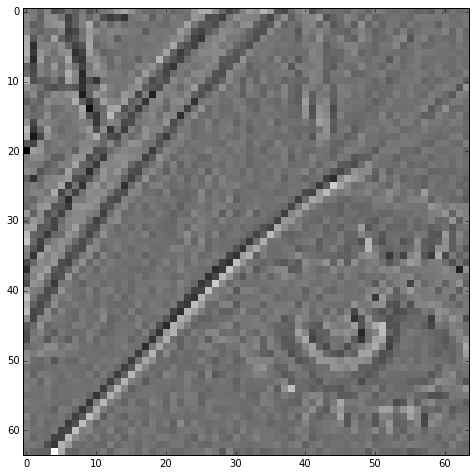

In [6]:
laplacian = cv2.Laplacian(img, ddepth=-1, scale=1)

plt.figure(figsize=(8, 8))
imgplt = plt.imshow(laplacian, "gray", interpolation="nearest")

__Gradient of laplacian__

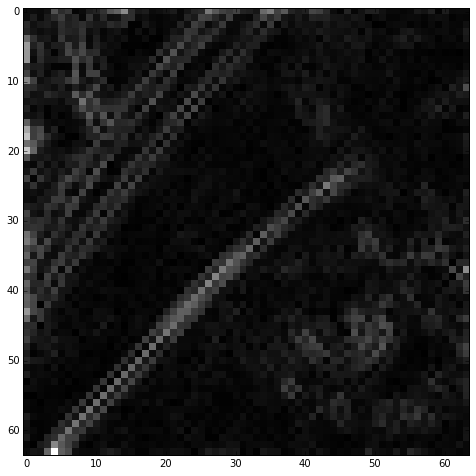

In [7]:
grad_of_lap = np.gradient(laplacian)

grad_of_lap_abs = np.sqrt(grad_of_lap[0]**2 + grad_of_lap[1]**2)
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(grad_of_lap_abs, "gray", interpolation="nearest")

Visualize gradient of laplacian

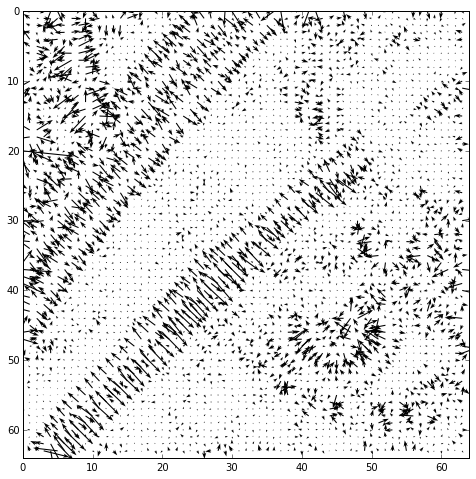

In [8]:
vx = grad_of_lap[1][y,x]
vy = grad_of_lap[0][y,x]

plt.figure(figsize=(8, 8))
plt.quiver(x, y, vx, -vy, pivot='origin', scale = 2000, headwidth=4, headlength=6)
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

__Final inner product__

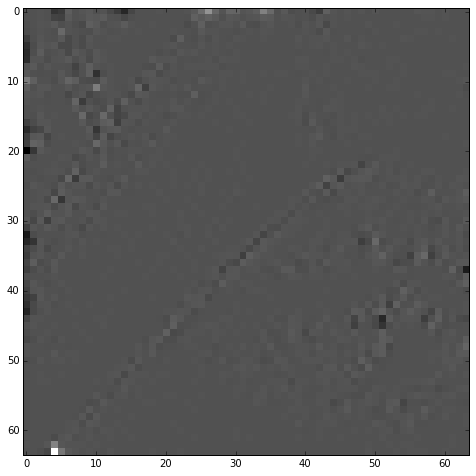

In [9]:
inner = grad_of_lap[0]*n[0] + grad_of_lap[1]*n[1]

plt.figure(figsize=(8, 8))
imgplt = plt.imshow(inner, "gray", interpolation="nearest")

http://docs.opencv.org/3.0-beta/modules/photo/doc/inpainting.html

##1. Non-local means inpainting - still image

A. Criminisi, P. Perez, and K. Toyama, “Object Removal by Exemplar-Based Image Inpainting,” Proc. IEEE Intl. Conference on Computer Vision, 2003.

A. Criminisi, P. Perez, and K. Toyama, “Region Filling and Object Removal by Exemplar-Based Image Inpainting,” IEEE Trans. Image Processing, vol. 13, no. 9, pp. 1200-1212, 2004.

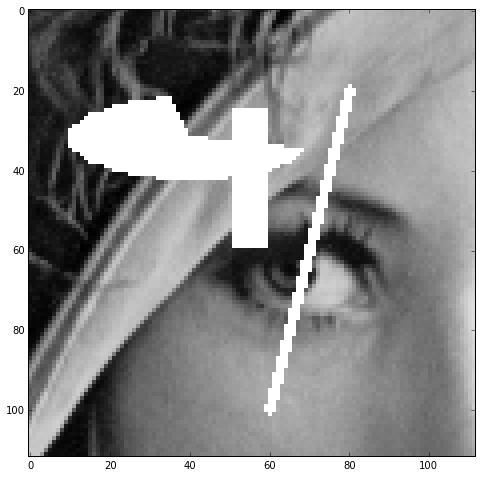

In [154]:
img_raw = cv2.cvtColor(cv2.imread('images/4.2.04.tiff'), cv2.COLOR_BGR2GRAY)
img_raw = img_raw[200:-200,200:-200]
#convert to float!
img_raw = img_raw.astype(np.float)

#img_orig = 127*np.ones_like(img_orig)
#img_orig[:,30:-30] = 0
#img_orig[:,10:23] = 0

#img_orig = cv2.cvtColor(cv2.imread('images/alice.png'), cv2.COLOR_BGR2GRAY)
#img_orig = img_orig[100:500,:]


#add some distorted region to fill
mask_orig = np.zeros_like(img_raw)
mask_orig = cv2.ellipse(mask_orig, (40,32), (30,10), 0, 20, 260, color=1, thickness=-1)
mask_orig[25:60,51:60] = 1
cv2.line(mask_orig, (60, 100), (80, 20), color=1, thickness=2) 

# distort image
img_orig = np.copy(img_raw)
img_orig[mask_orig == 1] = 255

# also initialize confidence term
confidence_orig = np.ones_like(img_raw)
confidence_orig[mask_orig==1] = 0

# copy & display
mask = np.copy(mask_orig)
img = np.copy(img_orig)
confidence = np.copy(confidence_orig)

plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img, "gray", interpolation="nearest")

In [155]:
# Calculate PSNR for image quality comparison
def psnr(i0, i1):
    mse = np.mean(np.square(i0 - i1))
    if mse == 0:  # prevent errors with log(0)
        mse = np.finfo(float).eps
    return np.round(20 * np.log10(255) - 10*np.log10(mse), 2)

print "PSNR=", psnr(img_orig, img_raw)

PSNR= 15.38


__Region contour δΩ__

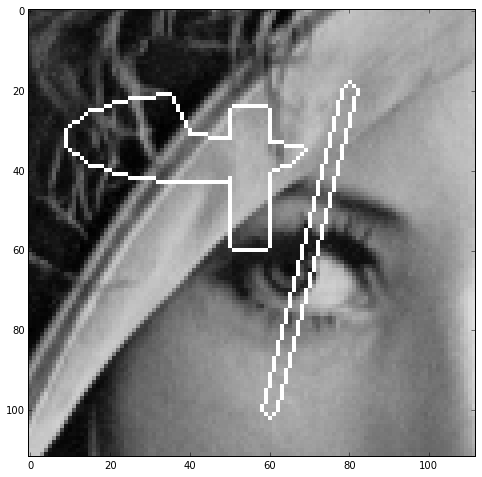

In [156]:
def get_src_boundary(img, mask):
    src_boundary = np.zeros_like(img)
    src_boundary[mask[:,1:]==1] = 1
    src_boundary[mask[1:,:]==1] = 1
    src_boundary[1:,:] = np.where(mask[:-1,:], 1, src_boundary[1:,:])
    src_boundary[:,1:] = np.where(mask[:,:-1], 1, src_boundary[:,1:])
    src_boundary[mask ==1] = 0
    return src_boundary

src_boundary = get_src_boundary(img, mask)

img_tmp = np.copy(img_raw)
plt.figure(figsize=(8, 8))
img_tmp[src_boundary ==1] = 255
imgplt = plt.imshow(img_tmp, "gray", interpolation="nearest")

__Gradient__

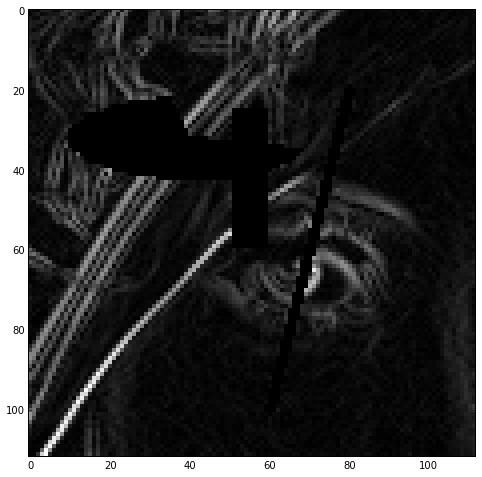

In [157]:
def get_grad(img, mask, src_boundary):
    grad = np.gradient(img)
    #normal = [np.zeros_like(grad[0]), np.zeros_like(grad[1])]

    grad_mask = np.copy(src_boundary)
    grad_mask[mask==1] = 1

    grad[0][grad_mask==1] = 0
    grad[1][grad_mask==1] = 0

    for y, x in zip(*np.where(src_boundary==1)):
        # gradient
        # work on x
        if not x == 0 and not mask[y,x-1] and not x == img.shape[1]-1 and not mask[y,x+1]:
            grad[1][y,x] = (img[y,x+1] - img[y,x-1])/2.    
        elif not x == 0 and not mask[y,x-1]:
            grad[1][y,x] = img[y,x] - img[y,x-1]
        elif not x == img.shape[1]-1 and not mask[y,x+1]:
            grad[1][y,x] = img[y,x+1] - img[y,x]
        else:
            grad[1][y,x] = 0
        # work on y
        if not y == 0 and not mask[y-1,x] and not y == img.shape[0]-1 and not mask[y+1,x]:
            grad[0][y,x] = (img[y+1,x] - img[y-1,x])/2.
        elif not y == 0 and not mask[y-1,x]:
            grad[0][y,x] = img[y,x] - img[y-1,x]
        elif not y == img.shape[0]-1 and not mask[y+1,x]:
            grad[0][y,x] = img[y+1,x] - img[y,x]
        else:
            grad[0][y,x] = 0

    return grad

grad = get_grad(img, mask, src_boundary)

get_isophote = lambda grad: (-1*grad[1], grad[0])  # abs of n and abs of grad are the same
isophote = get_isophote(grad) 

grad_abs = np.sqrt(grad[0]**2 + grad[1]**2)
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(grad_abs, "gray", interpolation="nearest")

__Calculate & visualize isophotes__

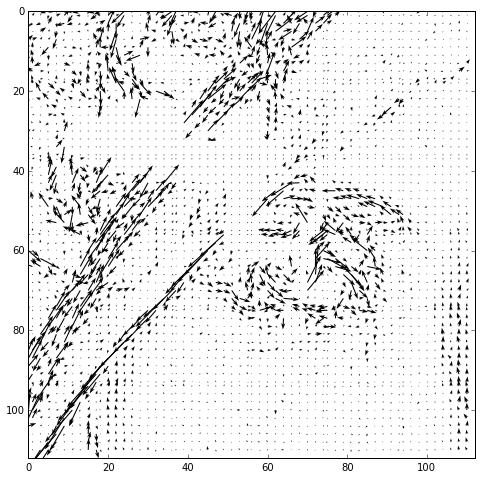

In [158]:
scale = 1000
num = 60
x = np.linspace(0, img.shape[1], num).astype(np.int)
y = np.linspace(0, img.shape[0], num).astype(np.int)
x, y = np.meshgrid(x[:-1], y[:-1])

#vx = grad[1][y,x]
#vy = grad[0][y,x] #axis is flipped!
vx = isophote[1][y,x]
vy = isophote[0][y,x] #axis is flipped!

plt.figure(figsize=(8, 8))
plt.quiver(x, y, vx, -vy, pivot='origin', scale=scale, headwidth=4, headlength=6)
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

__Calculate & visualize normal to the contour δΩ__

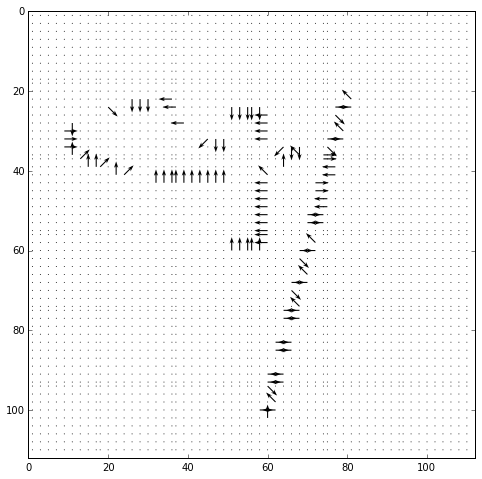

In [159]:
# calculate normal
def get_normal(img, mask, src_boundary):
    normal = np.gradient(mask)

    # set to 0 outside src boundary
    normal[0][np.where(src_boundary==0)] = 0
    normal[1][np.where(src_boundary==0)] = 0

    # normalize with abs value
    normal_abs = np.sqrt(normal[0]**2 + normal[1]**2)
    normal_abs[normal_abs==0] = 1
    normal = normal/normal_abs
    return normal

normal = get_normal(img, mask, src_boundary)
    
# display
n_scale = 30
vx = n_scale * normal[1][y,x]
vy = n_scale * normal[0][y,x] #axis is flipped!

plt.figure(figsize=(8, 8))
plt.quiver(x, y, vx, -vy, pivot='origin', scale=scale, headwidth=4, headlength=6)
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.show()

__Data term D(p): Calculate & visualize inner product between isophotes and normal to the contour δΩ__

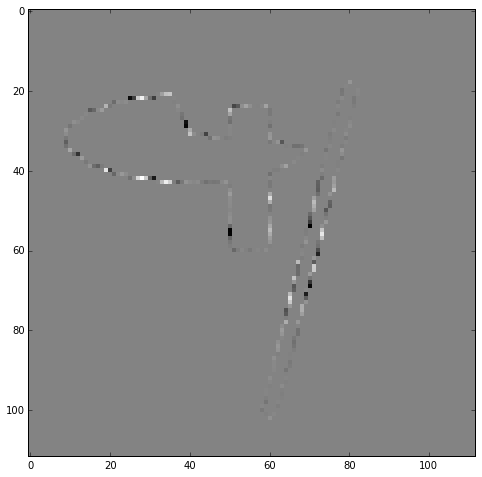

In [160]:
get_inner = lambda i,n : i[0]*n[0] + i[1]*n[1]

inner = get_inner(isophote, normal)

plt.figure(figsize=(8, 8))
#imgplt = plt.imshow(np.abs(inner), "gray", interpolation="nearest")
imgplt = plt.imshow(inner, "gray", interpolation="nearest")

__Confidence term C(p):__

Initial C(P) is 0 inside target region Ω, 1 oustide

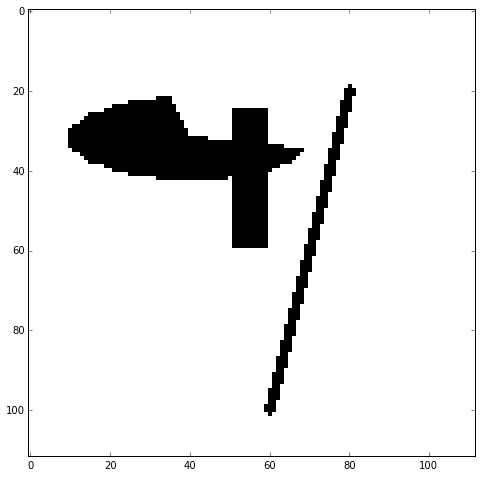

In [161]:
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(confidence, "gray", interpolation="nearest")

__Find patch with highest priority__ (To be inpainted)

Priority P(p) = C(p)*D(p)

C(p) ... Confidence term (1 for now)

D(p) ... Data term - inner product between isophotes and normal to the contour δΩ

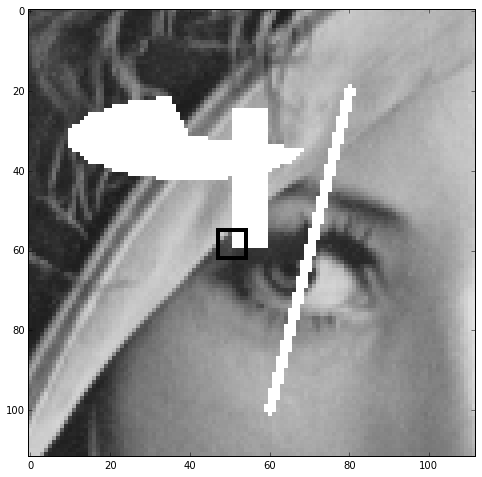

In [163]:
# define size of patch
patch_size = 7

def get_next_patch(inner, src_boundary, mask, patch_size):
    best = [[0,0],[patch_size, patch_size]]
    m = -1
    for y, x in zip(*np.where(src_boundary==1)):
        if x < patch_size/2 or y < patch_size/2 or x > img.shape[1] - patch_size/2 - 1 or y > img.shape[0] - patch_size/2 - 1:
            continue
        x0 = x - patch_size/2
        x1 = x + patch_size/2 + 1
        y0 = y - patch_size/2
        y1 = y + patch_size/2 + 1
        
        # data term D(p)
        inner_tmp =  inner[y0:y1, x0:x1]
        src_boundary_tmp =  src_boundary[y0:y1, x0:x1]
        inner_p = np.abs(np.average(inner_tmp[np.where(src_boundary_tmp == 1)]))
        Dp = inner_p/255.
        
        #condifence term - measure how many pixels were filled
        Cp = np.average(confidence[y0:y1, x0:x1])
        
        Pp = Dp * Cp
        if Pp > m:
            m = Pp
            best = [[y0,x0],[y1,x1]]
            best_Cp = Cp
    #print best, m, inner_p
    return best, best_Cp  # also return Cp for update

patch, Cp  = get_next_patch(inner, src_boundary, mask, patch_size)

img_tmp = np.copy(img)
img_tmp = cv2.rectangle(img_tmp, (patch[0][1], patch[0][0]), (patch[1][1], patch[1][0]), color=0, thickness=1)
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img_tmp, "gray", interpolation="nearest")

__Find non-local patch with smallest SSD__ (To be used in inpainting)

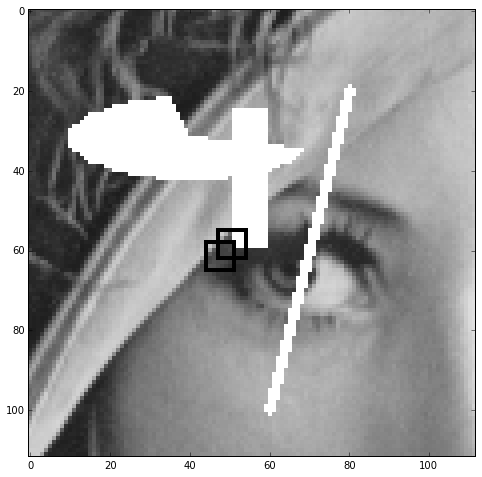

In [164]:
def patch_one_patch(img, patch, Cp, mask, mask_orig, confidence):
    
    mask_patch = mask[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]]
    confidence_patch = confidence[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]]
    image_patch = np.copy(img[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]])
    image_patch[mask_patch==1] = 0

    best = [[0,0], (255*patch_size)**2]
    
    for x in range(img.shape[1] - patch_size + 1):
        for y in range(img.shape[0] - patch_size + 1):
            # skip patches in region
            if np.max(mask_orig[y:y+patch_size,x:x+patch_size]==1):
            #if np.max(mask[y:y+patch_size,x:x+patch_size]==1):
                continue
            image_candidate = np.copy(img[y:y+patch_size,x:x+patch_size])
            image_candidate[mask_patch==1] = 0
            ssd = np.sum(np.square(image_patch - image_candidate))
            if ssd < best[1]:
                best[1] = ssd
                best[0] = [y,x]
                best_image_candidate = np.copy(image_candidate)
    [y,x] = best[0]
    
    image_candidate = np.copy(img[y:y+patch_size,x:x+patch_size])
    image_to_patch = img[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]]
    mask_to_patch = mask[patch[0][0]:patch[1][0], patch[0][1]:patch[1][1]]
    image_to_patch[mask_patch==1] = image_candidate[mask_patch==1]
    
    #update confidence
    confidence_patch[mask_patch==1] = Cp
    
    #FINALLY update mask
    mask_to_patch[mask_patch==1] = 0
    
    return [[y,x],[y+patch_size,x+patch_size]]

#apply
best = patch_one_patch(img, patch, Cp, mask, mask_orig, confidence)

img_tmp = cv2.rectangle(img_tmp, (best[0][1], best[0][0]), (best[1][1], best[1][0]), color=0, thickness=1)
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img_tmp, "gray", interpolation="nearest")

__Perform inpainting__

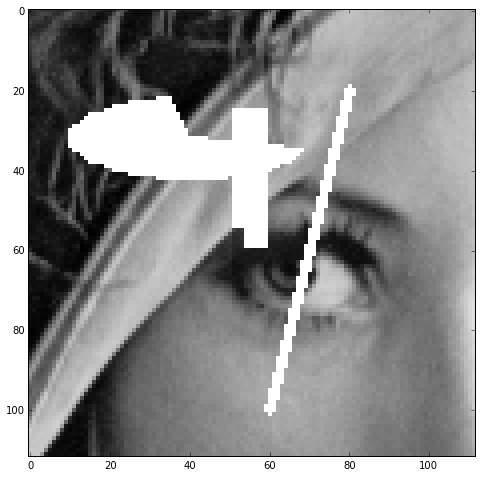

In [165]:
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img, "gray", interpolation="nearest")

###Automatic inpainting 
(Incl. GIF creation)

In [166]:
mask = np.copy(mask_orig)
img = np.copy(img_orig)
confidence = np.copy(confidence_orig)

print "Pixels to patch=", np.where(mask==1)[0].size

Pixels to patch= 1162


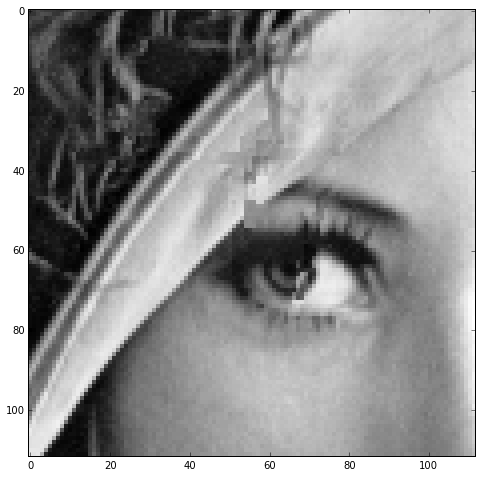

In [169]:
img_sequence = []

while True:
    # GIF creation
    img_c = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    img_sequence.append(cv2.resize(img_c, dsize=(0,0), fx=4, fy=4))

    n_points = np.where(mask==1)[0].size
    if n_points < 1:
        break
    src_boundary = get_src_boundary(img, mask)
    grad = get_grad(img, mask, src_boundary)
    isophote = get_isophote(grad) 
    normal = get_normal(img, mask, src_boundary)
    inner = get_inner(isophote, normal)
    patch, Cp = get_next_patch(inner, src_boundary, mask, patch_size)
    best = patch_one_patch(img, patch, Cp, mask, mask_orig, confidence)
   
    # GIF creation
    img_tmp = np.copy(img_c)
    img_tmp = cv2.rectangle(img_tmp, (patch[0][1], patch[0][0]), (patch[1][1], patch[1][0]), color=(255,0,0), thickness=1)
    img_sequence.append(cv2.resize(img_tmp, dsize=(0,0), fx=4, fy=4))
    img_tmp = cv2.rectangle(img_tmp, (best[0][1], best[0][0]), (best[1][1], best[1][0]), color=(0,255,0), thickness=1)
    img_sequence.append(cv2.resize(img_tmp, dsize=(0,0), fx=4, fy=4))

for i in range(8):
    img_sequence.append(cv2.resize(img_c, dsize=(0,0), fx=4, fy=4))

writeGif('images/inpainting.gif', img_sequence, duration=.40)

plt.figure(figsize=(8, 8))
imgplt = plt.imshow(img, "gray", interpolation="nearest")
#imgplt = plt.imshow(img_tmp, "gray", interpolation="nearest")

In [170]:
print "PSNR=", psnr(img, img_raw)

PSNR= 30.25


__Visualize the process__

![A](https://raw.githubusercontent.com/rmetchev/IVP-Python/master/images/inpainting.gif)

Show final confidence

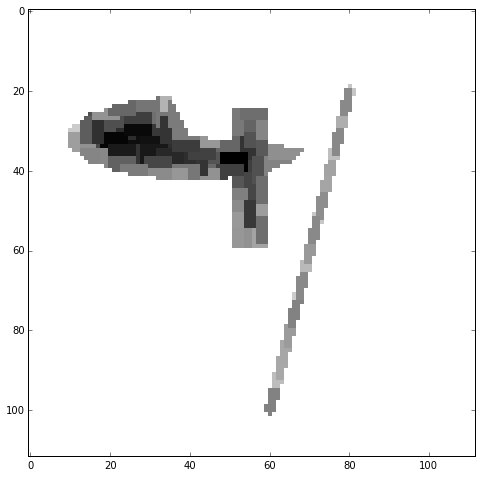

In [171]:
plt.figure(figsize=(8, 8))
imgplt = plt.imshow(confidence, "gray", interpolation="nearest")

__Artificial image 1__

In [262]:
img_orig = 200. * np.ones((200,400))
img_orig = cv2.circle(img_orig, (100,100), 80, color=0, thickness=-1)
img_orig = cv2.circle(img_orig, (300,100), 80, color=0, thickness=-1)
k = 7
img_orig = cv2.filter2D(img_orig, ddepth=-1, kernel=np.ones((k,k))/(k*k)) 
#imgplt = plt.imshow(img_orig, "gray", vmin=0, vmax=255, interpolation="nearest")

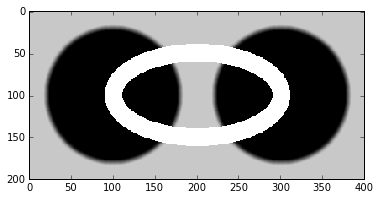

In [263]:
mask_orig = np.zeros((200,400))
mask_orig = cv2.ellipse(mask_orig, (200,100), (100,50), 0, 0, 360, color=1, thickness=20)

confidence = np.ones((200,400))
confidence[mask_orig==1] = 0
mask = np.copy(mask_orig)

img = np.copy(img_orig)
img[mask_orig==1] = 255.
imgplt = plt.imshow(img, "gray", vmin=0, vmax=255, interpolation="nearest")

In [264]:
print "PSNR=", psnr(img, img_orig)
print "Pixels to patch=", np.where(mask==1)[0].size

PSNR= 10.44
Pixels to patch= 10146


In [265]:
patch_size = 17
while True:
    n_points = np.where(mask==1)[0].size
    if n_points < 1:
        break
    src_boundary = get_src_boundary(img, mask)
    grad = get_grad(img, mask, src_boundary)
    isophote = get_isophote(grad) 
    normal = get_normal(img, mask, src_boundary)
    inner = get_inner(isophote, normal)
    patch, Cp = get_next_patch(inner, src_boundary, mask, patch_size)
    best = patch_one_patch(img, patch, Cp, mask, mask_orig, confidence)

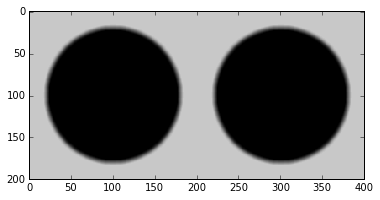

In [266]:
imgplt = plt.imshow(img, "gray", vmin=0, vmax=255, interpolation="nearest")

In [268]:
print "PSNR=", psnr(img, img_orig)

PSNR= 204.67


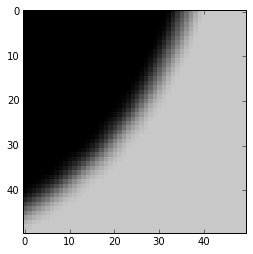

In [269]:
imgplt = plt.imshow(img[125:175,140:190], "gray", vmin=0, vmax=255, interpolation="nearest")

__Artificial image 2__

In [340]:
img_orig = 200. * np.ones((200,400))
tri = [np.array([(50,25), (50, 175), (250 , 100)], dtype= np.int32)]

img_orig = cv2.fillPoly(img_orig, tri, color=0) 
k = 9
img_orig = cv2.filter2D(img_orig, ddepth=-1, kernel=np.ones((k,k))/(k*k)) 

noise = np.random.normal(0, 50, img_orig.shape[:2]).astype(np.int)
img_orig = np.clip(img_orig + noise, 0, 255)

#imgplt = plt.imshow(img_orig, "gray", vmin=0, vmax=255, interpolation="nearest")

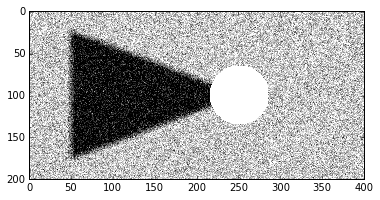

In [341]:
mask_orig = np.zeros((200,400))
mask_orig = cv2.circle(mask_orig, (250,100), 35, color=1, thickness=-1)

confidence = np.ones((200,400))
confidence[mask_orig==1] = 0
mask = np.copy(mask_orig)

img = np.copy(img_orig)
img[mask_orig==1] = 255.
imgplt = plt.imshow(img, "gray", vmin=0, vmax=255, interpolation="nearest")

In [342]:
print "PSNR=", psnr(img, img_orig)
print "Pixels to patch=", np.where(mask==1)[0].size

PSNR= 20.86
Pixels to patch= 3853


In [343]:
patch_size = 17
while True:
    n_points = np.where(mask==1)[0].size
    if n_points < 1:
        break
    src_boundary = get_src_boundary(img, mask)
    grad = get_grad(img, mask, src_boundary)
    isophote = get_isophote(grad) 
    normal = get_normal(img, mask, src_boundary)
    inner = get_inner(isophote, normal)
    patch, Cp = get_next_patch(inner, src_boundary, mask, patch_size)
    best = patch_one_patch(img, patch, Cp, mask, mask_orig, confidence)

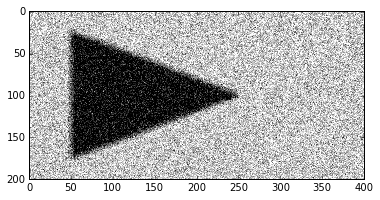

In [344]:
imgplt = plt.imshow(img, "gray", vmin=0, vmax=255, interpolation="nearest")

In [345]:
print "PSNR=", psnr(img, img_orig)

PSNR= 25.48


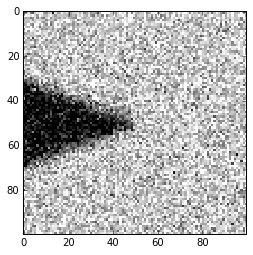

In [346]:
imgplt = plt.imshow(img[50:150,200:300], "gray", vmin=0, vmax=255, interpolation="nearest")